In [1]:
import numpy as np
import pandas as pd
import datetime
import glob
import os.path
from pandas.compat import StringIO

### NREL Bird Model implementation: for obtaining clear sky GHI

In [2]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
sns.set_color_codes()

In [4]:
import pvlib
from pvlib import clearsky, atmosphere
from pvlib.location import Location

In [5]:
bvl = Location(40.1134,-88.3695, 'US/Central', 217.932, 'Bondville')

In [6]:
times2009 = pd.DatetimeIndex(start='2009-01-01', end='2010-01-01', freq='1min',
                        tz=bvl.tz)   # 12 months of 2009 - For testing
times2010and2011 = pd.DatetimeIndex(start='2010-01-01', end='2012-01-01', freq='1min',
                        tz=bvl.tz)   # 24 months of 2010 and 2011 - For training

In [7]:
cs_2009 = bvl.get_clearsky(times2009) 
cs_2010and2011 = bvl.get_clearsky(times2010and2011) # ineichen with climatology table by default
#cs_2011 = bvl.get_clearsky(times2011) 

In [8]:
cs_2009.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
cs_2010and2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
#cs_2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns

In [9]:
cs_2009.reset_index(inplace=True)
cs_2010and2011.reset_index(inplace=True)
#cs_2011.reset_index(inplace=True)

In [10]:
cs_2009['index']=cs_2009['index'].apply(lambda x:x.to_datetime())
cs_2009['year'] = cs_2009['index'].apply(lambda x:x.year)
cs_2009['month'] = cs_2009['index'].apply(lambda x:x.month)
cs_2009['day'] = cs_2009['index'].apply(lambda x:x.day)
cs_2009['hour'] = cs_2009['index'].apply(lambda x:x.hour)
cs_2009['min'] = cs_2009['index'].apply(lambda x:x.minute)

In [11]:
cs_2010and2011['index']=cs_2010and2011['index'].apply(lambda x:x.to_datetime())
cs_2010and2011['year'] = cs_2010and2011['index'].apply(lambda x:x.year)
cs_2010and2011['month'] = cs_2010and2011['index'].apply(lambda x:x.month)
cs_2010and2011['day'] = cs_2010and2011['index'].apply(lambda x:x.day)
cs_2010and2011['hour'] = cs_2010and2011['index'].apply(lambda x:x.hour)
cs_2010and2011['min'] = cs_2010and2011['index'].apply(lambda x:x.minute)

In [12]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525601, 7)
(1051201, 7)


In [13]:
cs_2009.drop(cs_2009.index[-1], inplace=True)
cs_2010and2011.drop(cs_2010and2011.index[-1], inplace=True)
#cs_2011.drop(cs_2011.index[-1], inplace=True)

In [14]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525600, 7)
(1051200, 7)


In [15]:
cs_2010and2011.head()

,index,ghi,year,month,day,hour,min
0,2010-01-01 00:00:00-06:00,0.0,2010,1,1,0,0
1,2010-01-01 00:01:00-06:00,0.0,2010,1,1,0,1
2,2010-01-01 00:02:00-06:00,0.0,2010,1,1,0,2
3,2010-01-01 00:03:00-06:00,0.0,2010,1,1,0,3
4,2010-01-01 00:04:00-06:00,0.0,2010,1,1,0,4


### Import files from each year in a separate dataframe


- year            integer	 year, i.e., 1995
- jday            integer	 Julian day (1 through 365 [or 366])
- month           integer	 number of the month (1-12)
- day             integer	 day of the month(1-31)
- hour            integer	 hour of the day (0-23)
- min             integer	 minute of the hour (0-59)
- dt              real	 decimal time (hour.decimalminutes, e.g., 23.5 = 2330)
- zen             real	 solar zenith angle (degrees)
- dw_solar        real	 downwelling global solar (Watts m^-2)
- uw_solar        real	 upwelling global solar (Watts m^-2)
- direct_n        real	 direct-normal solar (Watts m^-2)
- diffuse         real	 downwelling diffuse solar (Watts m^-2)
- dw_ir           real	 downwelling thermal infrared (Watts m^-2)
- dw_casetemp     real	 downwelling IR case temp. (K)
- dw_dometemp     real	 downwelling IR dome temp. (K)
- uw_ir           real	 upwelling thermal infrared (Watts m^-2)
- uw_casetemp     real	 upwelling IR case temp. (K)
- uw_dometemp     real	 upwelling IR dome temp. (K)
- uvb             real	 global UVB (milliWatts m^-2)
- par             real	 photosynthetically active radiation (Watts m^-2)
- netsolar        real	 net solar (dw_solar - uw_solar) (Watts m^-2)
- netir           real	 net infrared (dw_ir - uw_ir) (Watts m^-2)
- totalnet        real	 net radiation (netsolar+netir) (Watts m^-2)
- temp            real	 10-meter air temperature (?C)
- rh              real	 relative humidity (%)
- windspd         real	 wind speed (ms^-1)
- winddir         real	 wind direction (degrees, clockwise from north)
- pressure        real	 station pressure (mb)


In [16]:
cols = ['year', 'jday', 'month', 'day','hour','min','dt','zen','dw_solar','dw_solar_QC','uw_solar',
       'uw_solar_QC', 'direct_n','direct_n_QC','diffuse', 'diffuse_QC', 'dw_ir', 'dw_ir_QC', 'dw_casetemp',
       'dw_casetemp_QC', 'dw_dometemp','dw_dometemp_QC','uw_ir', 'uw_ir_QC', 'uw_casetemp','uw_casetemp_QC',
       'uw_dometemp','uw_dometemp_QC','uvb','uvb_QC','par','par_QC','netsolar','netsolar_QC','netir','netir_QC',
       'totalnet','totalnet_QC','temp','temp_QC','rh','rh_QC','windspd','windspd_QC','winddir','winddir_QC',
       'pressure','pressure_QC']

In [17]:
path = r'.\\data\\Bondville\\Exp_1_train'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_train = pd.concat([pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files],ignore_index=True)
df_big_train.shape

(1050402, 48)

In [18]:
path = r'.\\data\\Bondville\\Exp_1_test'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_test = pd.concat((pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files),ignore_index=True)
df_big_test.shape

(524936, 48)

In [19]:
df_big_test[df_big_test['dw_solar']==-9999.9].shape

(19, 48)

### Merging Clear Sky GHI And the big dataframe

In [20]:
df_train = pd.merge(df_big_train, cs_2010and2011, on=['year','month','day','hour','min'])
df_train.shape

(1050402, 50)

In [21]:
df_test = pd.merge(df_big_test, cs_2009, on=['year','month','day','hour','min'])
df_test.shape

(524936, 50)

In [22]:
df_train.drop(['index'],axis=1, inplace=True) #updating the same dataframe by dropping the index columns from clear sky model
df_test.drop(['index'], axis=1, inplace=True)

In [23]:
df_train.shape

(1050402, 49)

### Managing missing values

In [24]:
# Resetting index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [25]:
# Dropping rows with two or more -9999.9 values in columns

In [26]:
# Step1: Get indices of all rows with 2 or more -999
missing_data_indices = np.where((df_train <=-9999.9).apply(sum, axis=1)>=2)[0]
# Step2: Drop those indices
df_train.drop(missing_data_indices, axis=0, inplace=True)
# Checking that the rows are dropped
df_train.shape

(1046527, 49)

In [27]:
missing_data_indices_test = np.where((df_test <= -9999.9).apply(sum, axis=1)>=2)[0]
df_test.drop(missing_data_indices_test, axis=0, inplace=True)
df_test.shape

(516826, 49)

In [28]:
# For the rows with only one cell as -9999.9, replacing this cell with the mean of the column

#### First resetting index after dropping rows in the previous part of the code

In [29]:
# 2nd time - Reseting Index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [30]:
one_miss_train_idx = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [31]:
len(one_miss_train_idx)

24739

In [32]:
df_train.shape

(1046527, 49)

In [33]:
col_names = df_train.columns
from collections import defaultdict
stats = defaultdict(int)
total_single_missing_values = 0
for name in col_names:
    col_mean = df_train[~(df_train[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_train[name] == -9999.9))
    stats[name] = len(missing_indices[0])
    df_train[name].loc[missing_indices] = col_mean
    total_single_missing_values += sum(df_train[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [34]:
df_col_min = df_train.apply(min, axis=0)
df_col_max = df_train.apply(max, axis =0)
#print(df_col_min, df_col_max)

In [35]:
train = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [36]:
len(train)

0

In [37]:
# doing the same thing on test dataset

In [38]:
one_miss_test_idx = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]
len(one_miss_test_idx)

15271

In [39]:
col_names_test = df_test.columns
from collections import defaultdict
stats_test = defaultdict(int)
total_single_missing_values_test = 0
for name in col_names_test:
    col_mean = df_test[~(df_test[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_test[name] == -9999.9))
    stats_test[name] = len(missing_indices[0])
    df_test[name].loc[missing_indices] = col_mean
    total_single_missing_values_test += sum(df_test[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
test = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]

In [41]:
len(test)

0

In [42]:
df_train.shape

(1046527, 49)

In [43]:
df_test.shape

(516826, 49)

### Exploratory Data Analysis

In [44]:
dw_solar_everyday = df_test.groupby(['jday'])['dw_solar'].mean()
ghi_everyday = df_test.groupby(['jday'])['ghi'].mean()
j_day = df_test['jday'].unique()

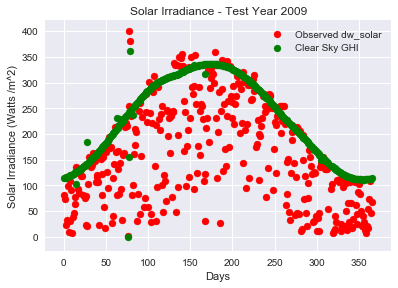

In [45]:
fig = plt.figure()

axes1 = fig.add_axes([0.1,0.1,0.8,0.8])
#axes2 = fig.add_axes([0.1,0.1,0.8,0.8])

axes1.scatter(j_day,dw_solar_everyday,label='Observed dw_solar',color='red')
axes1.scatter(j_day, ghi_everyday, label='Clear Sky GHI',color='green')

axes1.set_xlabel('Days')
axes1.set_ylabel('Solar Irradiance (Watts /m^2)')
axes1.set_title('Solar Irradiance - Test Year 2009')
axes1.legend(loc='best')

fig.savefig('Figure2a.png', bbox_inches = 'tight')

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


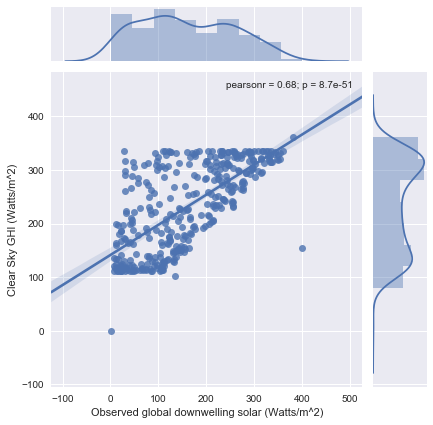

In [46]:
sns.jointplot(x=dw_solar_everyday,y=ghi_everyday,kind='reg')
#plt.title('observed dw_solar vs clear sky ghi')
plt.xlabel('Observed global downwelling solar (Watts/m^2)')
plt.ylabel('Clear Sky GHI (Watts/m^2)')
plt.savefig('Figure3a.png', bbox_inches='tight')

### making the Kt (clear sky index at time t) column by first removing rows with ghi==0

In [47]:
df_train = df_train[df_train['ghi']!=0]
df_test = df_test[df_test['ghi']!=0]
df_train['Kt'] = df_train['dw_solar']/df_train['ghi']
df_test['Kt'] = df_test['dw_solar']/df_test['ghi']

In [48]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [49]:
print("test Kt max: "+str(df_test['Kt'].max()))
print("test Kt min: "+str(df_test['Kt'].min()))
print("test Kt mean: "+str(df_test['Kt'].mean()))
print("\n")
print("train Kt max: "+str(df_train['Kt'].max()))
print("train Kt min: "+str(df_train['Kt'].min()))
print("train Kt mean: "+str(df_train['Kt'].mean()))

test Kt max: 44687.07900300023
test Kt min: -869.1104944675631
test Kt mean: 2.7894944379552764


train Kt max: 13966.236460411343
train Kt min: -1176.7698469370364
train Kt mean: 2.447186234312092


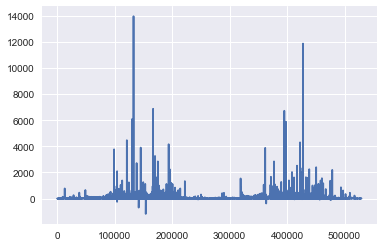

In [50]:
plt.plot(df_train['Kt'])

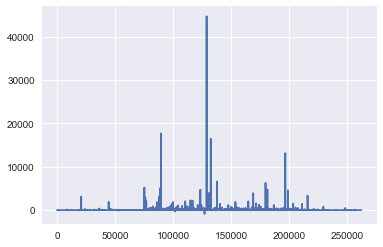

In [51]:
plt.plot(df_test['Kt'])

In [52]:
df_train= df_train[df_train['Kt']< 5000]
df_train= df_train[df_train['Kt']> -1000]
df_test= df_test[df_test['Kt']< 5000]
df_test= df_test[df_test['Kt']> -1000]

#### Group the data (train dataframe)

In [53]:
zen = df_train.groupby(['year','month','day','hour'])['zen'].mean()
dw_solar = df_train.groupby(['year','month','day','hour'])['dw_solar'].mean()
uw_solar = df_train.groupby(['year','month','day','hour'])['uw_solar'].mean()
direct_n = df_train.groupby(['year','month','day','hour'])['direct_n'].mean()
diffuse = df_train.groupby(['year','month','day','hour'])['diffuse'].mean()
dw_ir = df_train.groupby(['year','month','day','hour'])['dw_ir'].mean()
dw_casetemp = df_train.groupby(['year','month','day','hour'])['dw_casetemp'].mean()
dw_dometemp = df_train.groupby(['year','month','day','hour'])['dw_dometemp'].mean()
uw_ir = df_train.groupby(['year','month','day','hour'])['uw_ir'].mean()
uw_casetemp = df_train.groupby(['year','month','day','hour'])['uw_casetemp'].mean()
uw_dometemp = df_train.groupby(['year','month','day','hour'])['uw_dometemp'].mean()
uvb = df_train.groupby(['year','month','day','hour'])['uvb'].mean()
par = df_train.groupby(['year','month','day','hour'])['par'].mean()
netsolar = df_train.groupby(['year','month','day','hour'])['netsolar'].mean()
netir = df_train.groupby(['year','month','day','hour'])['netir'].mean()
totalnet = df_train.groupby(['year','month','day','hour'])['totalnet'].mean()
temp = df_train.groupby(['year','month','day','hour'])['temp'].mean()
rh = df_train.groupby(['year','month','day','hour'])['rh'].mean()
windspd = df_train.groupby(['year','month','day','hour'])['windspd'].mean()
winddir = df_train.groupby(['year','month','day','hour'])['winddir'].mean()
pressure = df_train.groupby(['year','month','day','hour'])['pressure'].mean()
ghi = df_train.groupby(['year','month','day','hour'])['ghi'].mean()
Kt = df_train.groupby(['year','month','day','hour'])['Kt'].mean()

In [54]:
df_new_train = pd.concat([zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,uw_dometemp,
                    uvb,par,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt], axis=1)

In [55]:
df_new_train.head()

zen  dw_solar  uw_solar  direct_n   diffuse  \
year   month day hour                                                       
2010.0 1.0   1.0 7.0   152.659762 -4.019048  0.026190  1.554762 -0.202381   
                 8.0   143.730167 -3.900000  0.030000  1.731667 -0.200000   
                 9.0   132.476167 -3.825000  0.011667  1.841667 -0.200000   
                 10.0  121.024000 -3.793333 -0.003333  1.783333 -0.210000   
                 11.0  109.724667 -3.703333  0.006667  1.758333 -0.210000   

                            dw_ir  dw_casetemp  dw_dometemp       uw_ir  \
year   month day hour                                                     
2010.0 1.0   1.0 7.0   182.345238   261.159524   260.650000  253.014286   
                 8.0   181.795000   260.780000   260.283333  251.493333   
                 9.0   181.033333   260.256667   259.761667  249.923333   
                 10.0  183.566667   259.941667   259.446667  249.775000   
                 11.0  191.770000   259.800000   259.353333  250.373333   

                       uw_casetemp    ...     netsolar      netir   totalnet  \
year   month day hour                 ...                                      
2010.0 1.0   1.0 7.0    259.557143    ...          0.0 -70.657143 -70.657143   
                 8.0    259.196667    ...          0.0 -69.693333 -69.693333   
                 9.0    258.665000    ...          0.0 -68.890000 -68.890000   
                 10.0   258.315000    ...          0.0 -66.203333 -66.203333   
                 11.0   258.070000    ...          0.0 -58.600000 -58.600000   

                            temp         rh   windspd     winddir  \
year   month day hour                                               
2010.0 1.0   1.0 7.0  -13.607143  83.883333  5.145238  293.504762   
                 8.0  -13.956667  84.893333  4.805000  296.086667   
                 9.0  -14.476667  85.781667  4.898333  295.981667   
                 10.0 -14.826667  85.966667  5.083333  298.381667   
                 11.0 -15.123333  86.431667  4.973333  299.090000   

                          pressure         ghi        Kt  
year   month day hour                                     
2010.0 1.0   1.0 7.0    999.397619   61.060726 -0.069829  
                 8.0    999.803333  166.338212 -0.025197  
                 9.0    999.783333  306.455432 -0.012680  
                 10.0   999.968333  411.028556 -0.009267  
                 11.0  1000.193333  465.002071 -0.007967  

[5 rows x 23 columns]

#### Groupdata - test dataframe

In [56]:
test_zen = df_test.groupby(['month','day','hour'])['zen'].mean()
test_dw_solar = df_test.groupby(['month','day','hour'])['dw_solar'].mean()
test_uw_solar = df_test.groupby(['month','day','hour'])['uw_solar'].mean()
test_direct_n = df_test.groupby(['month','day','hour'])['direct_n'].mean()
test_diffuse = df_test.groupby(['month','day','hour'])['diffuse'].mean()
test_dw_ir = df_test.groupby(['month','day','hour'])['dw_ir'].mean()
test_dw_casetemp = df_test.groupby(['month','day','hour'])['dw_casetemp'].mean()
test_dw_dometemp = df_test.groupby(['month','day','hour'])['dw_dometemp'].mean()
test_uw_ir = df_test.groupby(['month','day','hour'])['uw_ir'].mean()
test_uw_casetemp = df_test.groupby(['month','day','hour'])['uw_casetemp'].mean()
test_uw_dometemp = df_test.groupby(['month','day','hour'])['uw_dometemp'].mean()
test_uvb = df_test.groupby(['month','day','hour'])['uvb'].mean()
test_par = df_test.groupby(['month','day','hour'])['par'].mean()
test_netsolar = df_test.groupby(['month','day','hour'])['netsolar'].mean()
test_netir = df_test.groupby(['month','day','hour'])['netir'].mean()
test_totalnet = df_test.groupby(['month','day','hour'])['totalnet'].mean()
test_temp = df_test.groupby(['month','day','hour'])['temp'].mean()
test_rh = df_test.groupby(['month','day','hour'])['rh'].mean()
test_windspd = df_test.groupby(['month','day','hour'])['windspd'].mean()
test_winddir = df_test.groupby(['month','day','hour'])['winddir'].mean()
test_pressure = df_test.groupby(['month','day','hour'])['pressure'].mean()
test_ghi = df_test.groupby(['month','day','hour'])['ghi'].mean()
test_Kt = df_test.groupby(['month','day','hour'])['Kt'].mean()

In [57]:
df_new_test = pd.concat([test_zen,test_dw_solar,test_uw_solar,test_direct_n,test_diffuse,test_dw_ir,
                         test_dw_casetemp,test_dw_dometemp,test_uw_ir,test_uw_casetemp,test_uw_dometemp,
                    test_uvb,test_par,test_netsolar,test_netir,test_totalnet,test_temp,test_rh,
                         test_windspd,test_winddir,test_pressure,test_ghi,test_Kt], axis=1)

In [58]:
df_new_test.loc[2].xs(17,level='day')

,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
hour,,,,,,,,,,,,,,,,,,,,,
6.0,150.182143,-4.521429,-0.471429,1.007143,0.421429,216.700000,272.085714,271.642857,286.392857,270.300000,...,0.000000,-69.692857,-69.692857,-2.271429,89.750000,2.871429,174.300000,998.471429,37.874247,-0.120932
7.0,146.446833,-4.301667,-0.345000,0.326667,0.518333,216.170000,271.606667,271.146667,284.053333,269.938333,...,0.000000,-67.881667,-67.881667,-2.773333,92.965000,3.066667,146.796667,997.966667,108.318844,-0.050473
8.0,137.938333,-4.831667,-0.351667,1.045000,0.490000,216.516667,271.153333,270.733333,288.993333,269.398333,...,0.000000,-72.466667,-72.466667,-3.256667,94.690000,3.873333,152.585000,996.900000,284.228645,-0.017408
9.0,127.563000,-5.281667,-0.308333,0.951667,0.436667,223.628333,271.841667,271.390000,294.260000,269.860000,...,0.000000,-70.631667,-70.631667,-2.865000,91.560000,4.900000,164.426667,995.828333,448.178675,-0.011885
10.0,116.367333,-5.035000,-0.243333,0.833333,0.373333,236.190000,272.423333,271.983333,296.791667,270.326667,...,0.000000,-60.611667,-60.611667,-2.485000,89.688333,4.981667,173.578333,995.345000,570.306262,-0.008854
11.0,104.909333,-5.066667,-0.135000,0.480000,0.401667,233.243333,272.581667,272.093333,297.226667,270.480000,...,0.000000,-63.985000,-63.985000,-2.386667,92.431667,5.595000,167.585000,994.613333,638.422279,-0.007937
12.0,93.430833,-2.668333,0.580000,1.250000,3.091667,238.826667,272.686667,272.196667,298.433333,270.543333,...,2.351667,-59.603333,-57.251667,-2.320000,92.493333,6.421667,167.895000,993.798333,646.734117,-0.004067
13.0,82.473333,50.488333,14.828333,7.531667,57.045000,245.631667,273.396667,272.983333,302.830000,271.061667,...,43.403333,-57.188333,-13.786667,-1.801667,91.796667,6.791667,167.960000,993.278333,594.568596,0.086837
14.0,72.405000,136.151667,36.918333,13.550000,140.373333,286.001667,275.108333,274.810000,312.523333,272.315000,...,107.461667,-26.526667,80.938333,-0.561667,101.838333,7.736667,175.430000,992.623333,486.293072,0.287014


### Shifting Kt values to make 1 hour ahead forecast

#### Train dataset

In [59]:
levels_index= []
for m in df_new_train.index.levels:
    levels_index.append(m)

In [60]:
for i in levels_index[0]:
    for j in levels_index[1]:
        df_new_train.loc[i].loc[j]['Kt'] = df_new_train.loc[i].loc[j]['Kt'].shift(-2)

In [61]:
df_new_train = df_new_train[~(df_new_train['Kt'].isnull())]

#### Test dataset

In [62]:
levels_index2= []
for m in df_new_test.index.levels:
    levels_index2.append(m)

In [63]:
for i in levels_index2[0]:
    for j in levels_index2[1]:
        df_new_test.loc[i].loc[j]['Kt'] = df_new_test.loc[i].loc[j]['Kt'].shift(-2)

In [64]:
df_new_test = df_new_test[~(df_new_test['Kt'].isnull())]

In [65]:
df_new_test[df_new_test['Kt']==df_new_test['Kt'].max()]

,,,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
month,day,hour,,,,,,,,,,,,,,,,,,,,,
8.0,5.0,18.0,24.3985,903.236667,170.488333,609.081667,346.083333,382.34,304.0,303.905,482.805,300.676667,...,729.176667,-100.458333,628.715,25.17,68.681667,2.18,141.071667,992.59,201.959502,1146.230573


### Normalize train and test dataframe

In [66]:
train_norm = (df_new_train - df_new_train.mean()) / (df_new_train.max() - df_new_train.min())
test_norm =  (df_new_test - df_new_test.mean()) / (df_new_test.max() - df_new_test.min())

In [67]:
train_norm.reset_index(inplace=True,drop=True)
test_norm.reset_index(inplace=True,drop=True)

### Making train and test sets with train_norm and test_norm

#### finding the gcf (greatest common factor) of train and test dataset's length and chop off the extra rows to make it divisible with the batchsize

In [68]:
from fractions import gcd
gcd(train_norm.shape[0],test_norm.shape[0])

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  


1

In [69]:
import math
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

In [70]:
train_lim = roundup(train_norm.shape[0])
test_lim = roundup(test_norm.shape[0])

train_random = train_norm.sample(train_lim-train_norm.shape[0])
test_random = test_norm.sample(test_lim-test_norm.shape[0])

train_norm = train_norm.append(train_random)
test_norm = test_norm.append(test_random)

In [71]:
X1 = train_norm.drop('Kt',axis=1)
y1 = train_norm['Kt']

X2 = test_norm.drop('Kt',axis=1)
y2 = test_norm['Kt']

In [72]:
print("X1_train shape is {}".format(X1.shape))
print("y1_train shape is {}".format(y1.shape))
print("X2_test shape is {}".format(X2.shape))
print("y2_test shape is {}".format(y2.shape))

X1_train shape is (9600, 22)
y1_train shape is (9600,)
X2_test shape is (4100, 22)
y2_test shape is (4100,)


In [73]:
X_train = np.array(X1)
y_train  = np.array(y1)
X_test = np.array(X2)
y_test = np.array(y2)

### start of RNN

In [74]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [75]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        #Hidden Dimension
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        #Building the RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initializing the hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        #One time step (the last one perhaps?)
        out, hn = self.rnn(x, h0)
        
        # Indexing hidden state of the last time step
        # out.size() --> ??
        #out[:,-1,:] --> is it going to be 100,100
        out = self.fc(out[:,-1,:])
        # out.size() --> 100,1
        return out
        

In [76]:
# Instantiating Model Class
input_dim = 22
hidden_dim = 15
layer_dim = 1
output_dim = 1
batch_size = 100

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Instantiating Loss Class
criterion = nn.MSELoss()

# Instantiate Optimizer Class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# converting numpy array to torch tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

# initializing lists to store losses over epochs:
train_loss = []
test_loss = []
train_iter = []
test_iter = []

In [77]:
# Training the model
seq_dim = 1

n_iter =0
num_samples = len(X_train)
test_samples = len(X_test)
batch_size = 100
num_epochs = 1000
feat_dim = X_train.shape[1]

X_train = X_train.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

for epoch in range(num_epochs):
    for i in range(0, int(num_samples/batch_size -1)):
        
        
        features = Variable(X_train[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
        Kt_value = Variable(y_train[i*batch_size:(i+1)*batch_size])
        
        #print("Kt_value={}".format(Kt_value))
        
        optimizer.zero_grad()
        
        outputs = model(features)
        #print("outputs ={}".format(outputs))
        
        loss = criterion(outputs, Kt_value)
        
        train_loss.append(loss.data[0])
        train_iter.append(n_iter)

        #print("loss = {}".format(loss))
        loss.backward()
        
        optimizer.step()
        
         
            
        if n_iter%200 == 0:
            for i in range(0,int(test_samples/batch_size -1)):
                features = Variable(X_test[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
                Kt_test = Variable(y_test[i*batch_size:(i+1)*batch_size])
                
                outputs = model(features)
                
                mse = np.sqrt(np.mean((Kt_test.data.numpy() - outputs.data.numpy().squeeze())**2)/num_samples)
                
                test_iter.append(n_iter)
                test_loss.append(mse)
                
            print('Epoch: {} Iteration: {}. Train_MSE: {}. Test_MSE: {}'.format(epoch, n_iter, loss.data[0], mse))
        
        n_iter += 1 
               

Epoch: 0 Iteration: 0. Train_MSE: 0.003014477202668786. Test_MSE: 0.00043477852058157983
Epoch: 2 Iteration: 200. Train_MSE: 0.004386840853840113. Test_MSE: 0.00036709572612368793
Epoch: 4 Iteration: 400. Train_MSE: 0.003066215431317687. Test_MSE: 0.0003605415669057718
Epoch: 6 Iteration: 600. Train_MSE: 0.0017822093795984983. Test_MSE: 0.0003600953492064432
Epoch: 8 Iteration: 800. Train_MSE: 0.00207426305860281. Test_MSE: 0.0003561617319794113
Epoch: 10 Iteration: 1000. Train_MSE: 0.002230407204478979. Test_MSE: 0.0003476258395019613
Epoch: 12 Iteration: 1200. Train_MSE: 0.002361592836678028. Test_MSE: 0.00034094246726485176
Epoch: 14 Iteration: 1400. Train_MSE: 0.002364522311836481. Test_MSE: 0.0003348758525612563
Epoch: 16 Iteration: 1600. Train_MSE: 0.0012210470158606768. Test_MSE: 0.00032842937346032385
Epoch: 18 Iteration: 1800. Train_MSE: 0.0017839764477685094. Test_MSE: 0.0003223764149041517
Epoch: 21 Iteration: 2000. Train_MSE: 0.0020191252697259188. Test_MSE: 0.0003163717343

Epoch: 185 Iteration: 17600. Train_MSE: 0.0005426138523034751. Test_MSE: 0.00020202143248690315
Epoch: 187 Iteration: 17800. Train_MSE: 0.003650691593065858. Test_MSE: 0.00020178212351939652
Epoch: 189 Iteration: 18000. Train_MSE: 0.000443875091150403. Test_MSE: 0.00020064160818246375
Epoch: 191 Iteration: 18200. Train_MSE: 0.0002933972573373467. Test_MSE: 0.00019974744413793987
Epoch: 193 Iteration: 18400. Train_MSE: 0.0009730558376759291. Test_MSE: 0.00019870896984905284
Epoch: 195 Iteration: 18600. Train_MSE: 0.0034597229678183794. Test_MSE: 0.0001982531404439916
Epoch: 197 Iteration: 18800. Train_MSE: 0.00037943021743558347. Test_MSE: 0.00019818822373565462
Epoch: 200 Iteration: 19000. Train_MSE: 0.0007358342409133911. Test_MSE: 0.0001968781806197731
Epoch: 202 Iteration: 19200. Train_MSE: 0.0004081617807969451. Test_MSE: 0.0001961484743968021
Epoch: 204 Iteration: 19400. Train_MSE: 0.0009236788027919829. Test_MSE: 0.00019532634517155267
Epoch: 206 Iteration: 19600. Train_MSE: 0.00

Epoch: 366 Iteration: 34800. Train_MSE: 0.0003035461122635752. Test_MSE: 0.00015891483801617887
Epoch: 368 Iteration: 35000. Train_MSE: 0.00023158983094617724. Test_MSE: 0.000158540842647926
Epoch: 370 Iteration: 35200. Train_MSE: 0.0003292987239547074. Test_MSE: 0.000158228178054087
Epoch: 372 Iteration: 35400. Train_MSE: 0.0003114611026830971. Test_MSE: 0.00015749836294957857
Epoch: 374 Iteration: 35600. Train_MSE: 0.00035578940878622234. Test_MSE: 0.0001572258823361059
Epoch: 376 Iteration: 35800. Train_MSE: 0.00046435330295935273. Test_MSE: 0.0001573655193187588
Epoch: 378 Iteration: 36000. Train_MSE: 0.0003626819234341383. Test_MSE: 0.00015694447785142578
Epoch: 381 Iteration: 36200. Train_MSE: 0.0003351863124407828. Test_MSE: 0.00015651868663117192
Epoch: 383 Iteration: 36400. Train_MSE: 0.0003038130817003548. Test_MSE: 0.00015614888308113542
Epoch: 385 Iteration: 36600. Train_MSE: 0.00044844139483757317. Test_MSE: 0.00015576940488916258
Epoch: 387 Iteration: 36800. Train_MSE: 0.

Epoch: 547 Iteration: 52000. Train_MSE: 0.0035528549924492836. Test_MSE: 0.00013718625206656824
Epoch: 549 Iteration: 52200. Train_MSE: 0.0002511153288651258. Test_MSE: 0.00013684680918986812
Epoch: 551 Iteration: 52400. Train_MSE: 0.00012580069596879184. Test_MSE: 0.00013661389298185787
Epoch: 553 Iteration: 52600. Train_MSE: 0.0006487768259830773. Test_MSE: 0.00013647612053275352
Epoch: 555 Iteration: 52800. Train_MSE: 0.00314994715154171. Test_MSE: 0.00013633316670149875
Epoch: 557 Iteration: 53000. Train_MSE: 0.00029700304730795324. Test_MSE: 0.00013642609706429726
Epoch: 560 Iteration: 53200. Train_MSE: 0.0003417095576878637. Test_MSE: 0.00013593747324463416
Epoch: 562 Iteration: 53400. Train_MSE: 0.00018661684589460492. Test_MSE: 0.00013584095028115598
Epoch: 564 Iteration: 53600. Train_MSE: 0.0006838106201030314. Test_MSE: 0.00013559198090335858
Epoch: 566 Iteration: 53800. Train_MSE: 0.000261971348663792. Test_MSE: 0.00013547426759170746
Epoch: 568 Iteration: 54000. Train_MSE: 

Epoch: 728 Iteration: 69200. Train_MSE: 0.00010911999561358243. Test_MSE: 0.00012318548794628697
Epoch: 730 Iteration: 69400. Train_MSE: 0.00021242383809294552. Test_MSE: 0.00012307176598583738
Epoch: 732 Iteration: 69600. Train_MSE: 0.00018408335745334625. Test_MSE: 0.00012271578821299915
Epoch: 734 Iteration: 69800. Train_MSE: 0.00028543570078909397. Test_MSE: 0.00012268175903348827
Epoch: 736 Iteration: 70000. Train_MSE: 0.00041037629125639796. Test_MSE: 0.00012274630699712013
Epoch: 738 Iteration: 70200. Train_MSE: 0.00018506840569898486. Test_MSE: 0.00012262139872716351
Epoch: 741 Iteration: 70400. Train_MSE: 0.0002319767518201843. Test_MSE: 0.00012235919600368745
Epoch: 743 Iteration: 70600. Train_MSE: 0.00021902962180320174. Test_MSE: 0.00012220180031096418
Epoch: 745 Iteration: 70800. Train_MSE: 0.00039285593084059656. Test_MSE: 0.00012195900595929441
Epoch: 747 Iteration: 71000. Train_MSE: 0.0035461466759443283. Test_MSE: 0.00012196577955839673
Epoch: 749 Iteration: 71200. Tra

Epoch: 909 Iteration: 86400. Train_MSE: 0.0001749241928337142. Test_MSE: 0.0001126429900032378
Epoch: 911 Iteration: 86600. Train_MSE: 9.194156882585958e-05. Test_MSE: 0.0001124755594015487
Epoch: 913 Iteration: 86800. Train_MSE: 0.0005542532890103757. Test_MSE: 0.00011249296350164502
Epoch: 915 Iteration: 87000. Train_MSE: 0.0029788773972541094. Test_MSE: 0.00011237214048376817
Epoch: 917 Iteration: 87200. Train_MSE: 0.0002685431099962443. Test_MSE: 0.00011247326830122926
Epoch: 920 Iteration: 87400. Train_MSE: 0.00021243715309537947. Test_MSE: 0.00011215107578342248
Epoch: 922 Iteration: 87600. Train_MSE: 0.00012721138773486018. Test_MSE: 0.00011209595446968472
Epoch: 924 Iteration: 87800. Train_MSE: 0.0006184277008287609. Test_MSE: 0.0001119539926171645
Epoch: 926 Iteration: 88000. Train_MSE: 0.0002354812022531405. Test_MSE: 0.0001118121182718872
Epoch: 928 Iteration: 88200. Train_MSE: 8.767643157625571e-05. Test_MSE: 0.00011174935259330426
Epoch: 930 Iteration: 88400. Train_MSE: 0.

19000


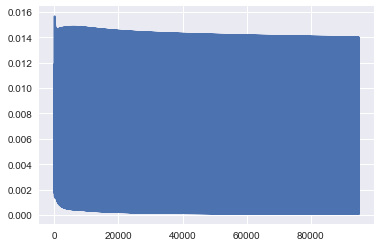

In [78]:
print(len(test_loss))
#plt.plot(test_loss)
plt.plot(train_loss,'-')
#plt.ylim([0.000,0.99])


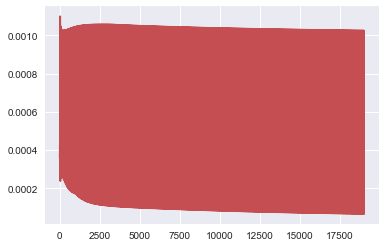

In [79]:
plt.plot(test_loss,'r')

#### Demornamization

In [80]:
rmse = np.sqrt(mse)

In [81]:
rmse_denorm = (rmse * (df_new_test['Kt'].max() - df_new_test['Kt'].min()))+ df_new_test['Kt'].mean()

In [82]:
rmse_denorm

17.810984861107954

In [83]:
df_new_test['Kt'].describe()

count    4001.000000
mean        5.870793
std        30.554212
min        -0.030773
25%        -0.007258
50%         0.166769
75%         1.241848
max      1146.230573
Name: Kt, dtype: float64

### Saving train and test losses to a csv

In [84]:
df_trainLoss = pd.DataFrame(data={'Train Loss':train_loss, 'iteration':train_iter}, columns=['Train Loss','iteration'])
df_trainLoss.to_csv('RNN Paper Results/Exp1_Bondville_TrainLoss.csv')
df_testLoss = pd.DataFrame(data={'Test Loss':test_loss,'iteration':test_iter}, columns=['Test Loss','iteration'])
df_testLoss.to_csv('RNN Paper Results/Exp1_Bondville_TestLoss.csv')